In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute the Budget mean, STD and CV

The budget is defined as the combination of two phenomena:
- Uncertainty due to the segmentation of the lesion by the radiologists (ROI uncertainty)
- Uncertainty due to the registration of the image. This can also be refered as displacement uncertainty as it is related to the movement of the patient during the acquisition of the time images

Important: Martha_2 segmentation is removed due to the outliers present in the data, clearly related with the heteregenous delineation of the lesion.

In [2]:
# files
budget_dir = repo_path / 'data/budget'
# get all folders in the budget directory (2 per radiologist)
budget_folders = [x for x in budget_dir.iterdir() if x.is_dir()]
#remove M_2
budget_folders = [x for x in budget_folders if 'M_2' not in str(x)] # remove Martha 2
print(f'The number of folders is {len(budget_folders)}')
# get all files in each folder in the same list
budget_files = [x for folder in budget_folders for x in folder.iterdir() if x.is_file()]
print(f'The number of files is {len(budget_files)}')

The number of folders is 5
The number of files is 65


Now that all files are obtained (65), the budget can be computed. <br>
The budget is defined as the variation of the feature due to both ROI and registration uncertainty. As such it is the standard deviation of the feature value among the 65 files. <br>
Because the values of the features are different between features, a coefficient of variation (CV) is computed as the ratio between the budget and the mean of the feature. <br>

In [3]:
# read each indpendent csv file and stack them in a single dataframe
budget_df = pd.concat([pd.read_csv(file) for file in budget_files], ignore_index=True)
# get mean of only pat_num 2 patients
budget_mean = budget_df.groupby('pat_num').mean()
budget_std = budget_df.groupby('pat_num').std()
budget_cv = budget_std/budget_mean

# save files
budget_mean.to_csv(budget_dir / 'budget_mean.csv')
budget_std.to_csv(budget_dir / 'budget_std.csv')
budget_cv.to_csv(budget_dir / 'budget_cv.csv')

Define budget as mean of Cvs

In [4]:
# mean of budget_cv
budget_cv_mean = budget_cv.mean().abs()
budget_cv_mean.to_csv(budget_dir / 'budget_ROI_and_rad.csv')

In [37]:
# # create budget cv as std/mean only if budget_df.max() > 1
# budget_cv = budget_std.copy()
# for col in budget_cv.columns:
#     if budget_mean[col].max() > 1:
#         budget_cv[col] = budget_cv[col] / budget_mean[col]
#         print(f'The max value for {col} is {budget_mean[col].max()}')

# Cv vs STD

In [5]:
# # graph budget mean vs std
# for key in budget_mean.keys():
#     # check if the mean values are all less than 1, if so make the points blue, else red
#     color = 'blue' if budget_mean[key].max() < 1 else 'red'
#     # plt 2 graphs in one figure
#     fig, ax = plt.subplots(1,2, figsize=(20,10))
#     # change the color of the points
#     ax[0].scatter(budget_mean[key], budget_std[key], c=color)
#     ax[0].set_xlabel('mean')
#     ax[0].set_ylabel('std')
#     ax[0].set_title(f'Mean vs Std for {key.split("_")[1]}')
#     ax[1].scatter(budget_mean[key], budget_cv[key], c=color)
#     ax[1].set_xlabel('mean')
#     ax[1].set_ylabel('cv')
#     ax[1].set_title(f'Mean vs CV for {key.split("_")[1]}')
#     plt.show()

Text(0, 0.5, 'Correlation')

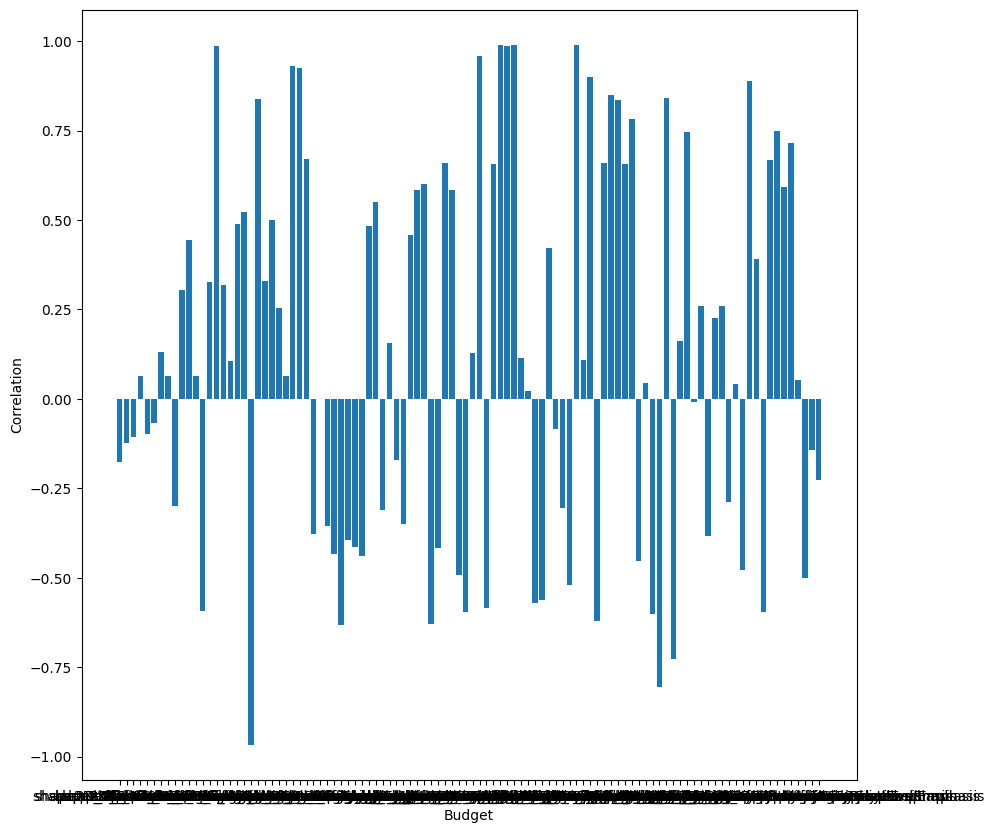

In [5]:
# graph the correlation value for each key
corr_list = []
for key in budget_mean.keys():
    # check if mean values are less than 1, if true give the bar color blue, else give it red
    corr, p = pearsonr(budget_mean[key], budget_cv[key])
    corr_list.append(corr)
plt.figure(figsize=(10,10))
plt.bar(budget_mean.keys(), corr_list)
plt.xlabel('Budget')
plt.ylabel('Correlation')
